### Fine-tune the pre-trained FaceNet model towards the Caltech Face Dataset (450 images, 30 peaple) using triplet loss function

In [1]:
import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input, Subtract, add, Dot
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler



Using TensorFlow backend.


In [2]:
from utils.FaceNet_utils import one_hot, distance_based_prediction, evaluate_model, face_dist, load_FaceData, load_base_model

In [3]:
nFace = 450

In [36]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

#     anchorpositive, anchornegative = y_pred[0], y_pred[1]

#     ### START CODE HERE ### (≈ 4 lines)
#     # Step 1: Compute the (encoding) distance between the anchor and the positive
#     pos_dist = K.sum(K.square(anchorpositive),axis=-1)
#     # Step 2: Compute the (encoding) distance between the anchor and the negative
#     neg_dist = K.sum(K.square(anchornegative),axis=-1)
#     # Step 3: subtract the two previous distances and add alpha.
#     basic_loss = pos_dist - neg_dist + alpha
#     # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
#     loss = K.sum(K.maximum(basic_loss,0.0))
#     ### END CODE HERE ###

    loss = K.sum(K.maximum(y_pred+alpha,0.0))

    return loss

In [5]:
def VecDist(tensors):
    dist = K.sum(K.square(tensors[0]-tensors[1]),axis=-1)
    return dist

In [46]:
def Create_Siamese_model(basemodel,alpha = 0.2):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    Anchor_Input    = Input(basemodel_input_shape)
    Positive_Input  = Input(basemodel_input_shape)
    Negative_Input  = Input(basemodel_input_shape)
    
    Anchor_Predict   = basemodel(Anchor_Input)
    Positive_Predict = basemodel(Positive_Input)
    Negative_Predict = basemodel(Negative_Input)

    AP_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Positive_Predict])
    AN_dist = Lambda(VecDist, output_shape=(1,))([Anchor_Predict,Negative_Predict])

    print(AP_dist,AN_dist)
    APN = Subtract()([AP_dist,AN_dist])
    print(APN)
                     
    SiameseModel = Model(inputs = [Anchor_Input, Positive_Input, Negative_Input], outputs = APN)
    
    return SiameseModel 

In [7]:
FNModel = load_base_model()

In [8]:
FNModel.count_params()

3743280

In [9]:
FaceData, labels, labels_OH = load_FaceData()
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)

(450, 3, 96, 96)
(450,)
(450, 31)


In [10]:
nPeople = labels_OH.shape[1]

In [11]:
FaceEmbedding = FNModel.predict(FaceData)

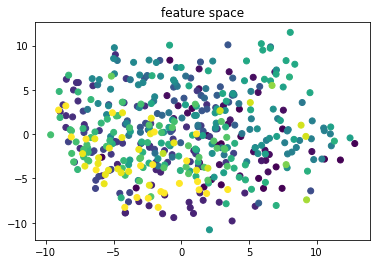

In [60]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

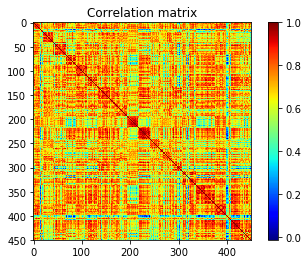

In [15]:
FaceEmbedding_Corr = np.corrcoef(FaceEmbedding)
plt.imshow(FaceEmbedding_Corr,cmap='jet')
plt.title('Correlation matrix')
plt.colorbar()

In [16]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

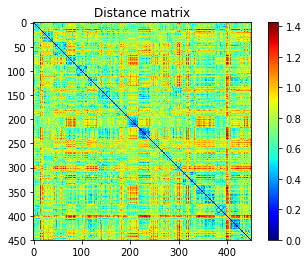

In [17]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.798 +\- 0.168
Same-class distance = 0.514 +\- 0.229


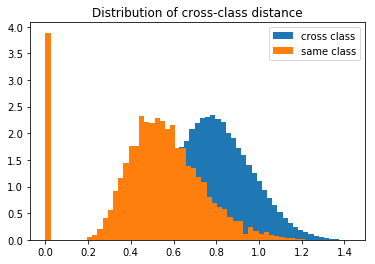

In [18]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

### Note:
Even before doing anything, the direct embedding of faces using FaceNet is already able to recognize faces at decent level.

pct of false positive 25.571 %
pct of false negative 20.925 %
accuracy = 74.647


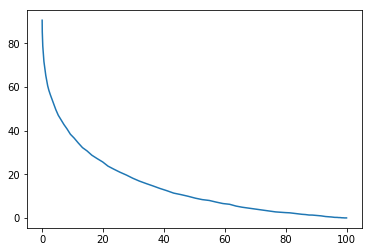

In [19]:
FP = []
FN = []

for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    
plt.plot(FP,FN)  
threshold = 0.68
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [20]:
train_idx = []
test_idx = []
for l in set(labels):
    ind = np.where(labels==l)[0]
    if len(ind)<=1:
        ind_train = list(ind)
        ind_test = []
    else:
        i_split = max([3,int(len(ind)*0.7)])
        ind_train = list(ind[0:i_split])
        ind_test = list(ind[i_split:])
    train_idx += ind_train
    test_idx += ind_test  
print("Training data set has %d face images", len(train_idx))
print("Test data set has %d face images", len(test_idx))

Training data set has %d face images 307
Test data set has %d face images 143


In [21]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 78.322 %


## Generate Anchor, positive and negative combinations to train Siamese model built on top of the FaceNet model

In [47]:
SiameseModel = Create_Siamese_model(FNModel)

Tensor("lambda_6/Sum:0", shape=(?,), dtype=float32) Tensor("lambda_7/Sum:0", shape=(?,), dtype=float32)
Tensor("subtract_9/sub:0", shape=(?,), dtype=float32)


In [48]:
SiameseModel.output

<tf.Tensor 'subtract_9/sub:0' shape=(?,) dtype=float32>

In [49]:
SiameseModel.compile(optimizer = 'adam', loss = triplet_loss)

In [50]:
SiameseModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 3, 96, 96)     0                                            
____________________________________________________________________________________________________
input_8 (InputLayer)             (None, 3, 96, 96)     0                                            
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 3, 96, 96)     0                                            
____________________________________________________________________________________________________
FaceRecoModel (Model)            (None, 128)           3743280     input_7[0][0]                    
                                                                   input_8[0][0]           

In [51]:
nFace

450

In [52]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold = 0.3
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold).sum()
        #nNegativeFaces = max(1,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

In [53]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)

269 number of A, P, N combinations had been identified


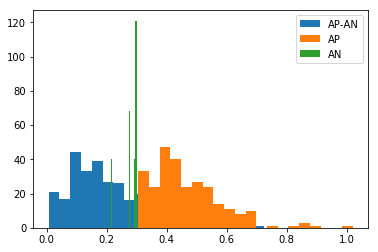

APN = 0.187 +\- 0.117
AP = 0.465 +\- 0.117
AN = 0.279 +\- 0.028


In [54]:
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [59]:
#SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 1, batch_size = 4)

Epoch 1/1
269/269 [==============================] - 152s - loss: 0.0357   


In [61]:
FaceEmbedding = FNModel.predict(FaceData)

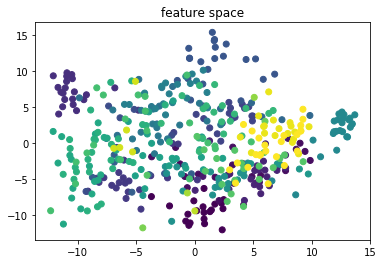

In [62]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

In [63]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 82.517 %


In [64]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

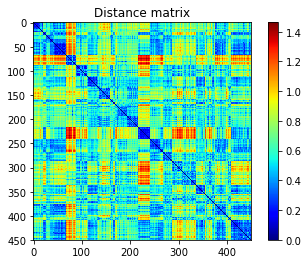

In [65]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.657 +\- 0.213
Same-class distance = 0.303 +\- 0.160


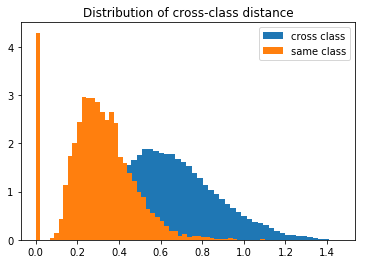

In [66]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

### Note
After only 1 epoch of training on Siamese model, the prediction accuracy based on embedding distance has increased from 78.3% to 82.5%

In [67]:
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], np.zeros((nAPN,)), epochs = 5, batch_size = 4)

Epoch 1/5
269/269 [==============================] - 153s - loss: 0.0424   
Epoch 2/5
269/269 [==============================] - 155s - loss: 0.0422   
Epoch 3/5
269/269 [==============================] - 159s - loss: 0.0202   
Epoch 4/5
269/269 [==============================] - 156s - loss: 0.0269   
Epoch 5/5
269/269 [==============================] - 154s - loss: 0.0054   


In [68]:
FaceEmbedding = FNModel.predict(FaceData)

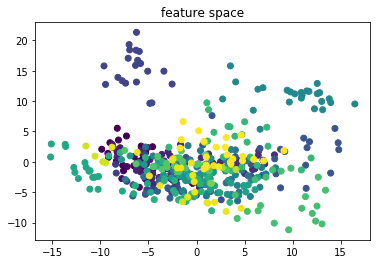

In [69]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

In [70]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 79.021 %


Cross-class distance = 0.578 +\- 0.225
Same-class distance = 0.248 +\- 0.137


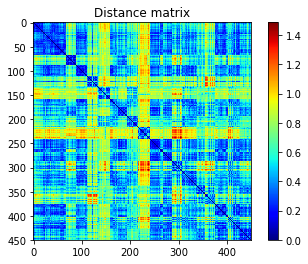

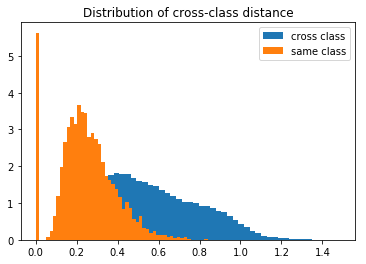

In [71]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))